# The diagnosis of the plant ionome with `R`

I have written several papers on the subject, namely on [tomato](https://doi.org/10.3389/fpls.2017.00825), [guava](https://doi.org/10.3389/fpls.2016.01252), [kiwi](https://doi.org/10.1080/00103624.2014.989031), [corn](http://dx.doi.org/10.4236/ajps.2014.54064) and [mango](https://doi.org/10.3389/fpls.2013.00449). As conceptual papers [as](https://doi.org/10.3389/fpls.2013.00039) [well](https://www.researchgate.net/profile/Leon_Parent2/publication/318275787_Balance_designs_revisit_indices_commonly_used_in_agricultural_science_and_eco-engineering/links/595f7869aca2728c116ed7ac/Balance-designs-revisit-indices-commonly-used-in-agricultural-science-and-eco-engineering.pdf?_iepl%5BhomeFeedViewId%5D=WGt2J2tZMBgHrDu0f894gbN4&_iepl%5Bcontexts%5D%5B0%5D=pcfhf&_iepl%5BinteractionType%5D=publicationDownload&origin=publication_detail&ev=pub_int_prw_xdl&msrp=jNdouIpsVE9XXZM64BqhX-QZOYxkJio63F5eYVxsTgpXcSJILL5jTtgInWcrVG6A-EHy3x-DGK7satbkdtZ30xKiWFp6haEHsroz3cXW8Il6MzLQ9rQ34I70.f1IiylxL3BDdSk6kC0ypHZqMZTmNIjpGvwbX-Y_eCRasznqWGyySRCFRuoiHPSk5jyC3zJ4L-NPsggAtq8k6n9LgKJkI9ZSEHNrbKg.TsV9H4fvzhNxJE-dibQoXY3O4r129c4shwJB8aR22Uam8ZjYQEiq8HKiPQUZuyA-Yk8Fyg0RTwOHSyB9w8q3qMK7rV6LwL7fIIlWcA.bzlOVBIu2PhJ-pGG3emYDelFuq98a7iMbI10Kf8N6YQOH6FV8MADY44W_0JYpFyCyFNKtwpmb0ijtsfLEl0KUfJioL2FLf_Vi2mN5Q). I have been asked several times how the calculations were done. I now tend to publish all my codes and data on [my GitHub repository](https://github.com/essicolo), but in the past this was not so systematic. This notebook is for people who want to know how I work with plant ionomes with `R`.

One of the reasons why science is beautiful is that knowledge moves through better accuracies. When I worked with mango ionomes, I created an *in-house* code to isolate a high-yield, healthy group, then assessed the health index of an ionome by computing the Mahalanobis distance between the observation to diagnose and the center and covariance of the healthy group (Mahalanobis distances need covariance).

Nowadays, I prefer to use established machine learning methods. In particular, a distance-based method named *k-nearest neighbors* offers insightful results. I'm not saying it's a catch-all approach. There are probably better methods waiting to be discovered. And this notebook will be improved over time, just like a wiki.

## Load libraries

I'm loading `tidyverse` to load both `ggplot2` and `dplyr`. `compositions` is a package to transform components (like concentrations) to compositionnally friendly variables, like isometric log-ratios. This package has not been updated for a while, so if you are on Windows, `R` will throw warnings, which as far as I know can be ignored. The `mvoutlier` package is usefull to detect multivariate outliers. If you are a `R` user and don't know `caret`, you are missing something huge: it's a all-in-one package for machine learning. The `MASS` package contains some useful functions, namely `ginv` for matrix inversion (used to compute the Mahalanobis distance.)

In [5]:
library("tidyverse")
library("compositions")
library("mvoutlier")
library("caret")
library("MASS")

sROC 0.1-2 loaded
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:compositions':

    R2

The following object is masked from 'package:purrr':

    lift


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select



There are tools that are unavailable in packages. So I created some code and put them in my [`AgFun` repository on GitHub](https://github.com/essicolo/AgFun) (fun is for *fun*ction, of course - who would think these things are fun?!?).

In [6]:
source("https://raw.githubusercontent.com/essicolo/AgFun/master/DRIS.R") # DRIS
source("https://raw.githubusercontent.com/essicolo/AgFun/master/sign1_ref.R") # Mahalanobis
source("https://raw.githubusercontent.com/essicolo/AgFun/master/codadend2.R") # CoDaDendrogram2
source("https://raw.githubusercontent.com/essicolo/AgFun/master/ilrDefinition.R") # ilrDefinition
source("https://raw.githubusercontent.com/essicolo/AgFun/master/CateNelson.R") # CateNelson
source("https://raw.githubusercontent.com/essicolo/AgFun/master/biclass.R") # biclass

DRIS stands for Diagnosis and Recommandation Integrated System. It's a mathematical formulation created by Beaufils () to assess plant ionomes. The `sign1_ref` function is inspired by the `sign1` function of the `mvoutlier` package: it does the isolation of a healthy group and computes Mahalanobis distances. The `codadend2.R` fil contains the `CoDaDendrogram2` function. It's a fork of the `CoDaDendrogram` function from the `compositions` package which mostly adds the ability to plot statistics on the vertical branches. The `ilrDefinition.R` file contains a function that generates `[E,D | C,B,A]` strings from a sequential binary partition (a SBP, used to give a structure to isometric log-ratios). The `CateNelson.R` and the `biclass.R` files contain respectively a function to plot Cate-Nelson data and to classify these data in binary classes.

## Load data

The data set comes from cranberries. When there are numerous components to analyse, I prefer to design SBPs in a spreadsheet (LibreOffice Calc) rather than entering it in `R`.

In [7]:
atoca <- read.csv('https://raw.githubusercontent.com/essicolo/AgFun/master/examples/plant-ionome-diagnosis-with-R/data/data.csv', sep=';')
sbp <- read.csv('https://raw.githubusercontent.com/essicolo/AgFun/master/examples/plant-ionome-diagnosis-with-R/data/sbp.csv', sep=';')

In [8]:
atoca[220:230, ]

,Annee,Site,Type,Dose,RÃ.pÃ.tition,Rendement,B,Ca,Cu,Fe,K,Mg,Mn,P,Zn,N,C,S
220,2015,9,N,30,1,24.30,55.04,6146.643,0.583,80.928,4054.872,1507.094,209.229,654.056,36.893,7655.7,500290,327.2
221,2015,9,N,30,2,23.31,44.32,5334.366,0.876,19.275,4804.615,1620.087,137.948,719.722,36.487,9259.8,508480,392.0
222,2015,9,N,45,1,42.99,48.10,5722.822,1.254,57.678,4895.000,1355.771,204.122,715.135,34.422,10532.0,503640,580.8
223,2015,9,N,45,2,41.15,43.06,5475.759,0.730,24.684,4379.072,1531.016,163.708,816.485,38.090,10930.0,505740,490.1
224,2015,9,N,60,1,25.47,37.77,5087.231,1.065,44.547,4914.364,1325.100,197.556,759.772,41.015,11870.0,509600,644.8
225,2015,9,N,60,2,32.35,31.77,5368.080,1.719,0.000,5585.483,1367.317,172.310,962.050,35.234,12677.0,503840,558.7
226,2015,9,P,0,1,41.97,50.28,5046.828,0.521,61.285,4323.620,1440.099,195.842,645.899,44.769,8132.4,499680,456.3
227,2015,9,P,0,2,23.68,48.31,6128.005,0.886,65.895,4729.276,1543.901,218.785,674.994,38.642,12760.0,506590,645.2
228,2015,9,P,15,1,35.31,58.86,6034.661,0.943,94.491,4768.038,1510.485,190.375,731.000,37.364,10076.0,507790,657.0
229,2015,9,P,15,2,32.95,44.65,5832.912,1.048,17.409,4664.825,1495.766,178.911,783.511,41.554,10902.0,507400,678.7


I use a filling value (`Fv`), representing all the components which were not measured (here mostly oxigen and hydrogen) in the leaves. This is useful not only in the diagnostic, but also it's necessary to back-transform isometric log-ratios to concentrations in the original scale.

In [11]:
parts <- atoca[ ,7:18]
if (!'Fv' %in% colnames(parts)) parts$Fv <- 1e6 - rowSums(parts)

It's always useful to check if the column names in parts and sbp are the same.

In [12]:
t(data.frame(colnames(sbp), colnames(parts)))

colnames.sbp.,B,Ca,Cu,Fe,K,Mg,Mn,P,Zn,N,C,S,Fv
colnames.parts.,B,Ca,Cu,Fe,K,Mg,Mn,P,Zn,N,C,S,Fv


## Compositional data analysis
In this section, I transform the parts to balances. This is done to free concentrations from their closed space, from their redundancy and from their subcompositional incoherence ([this paper](https://doi.org/10.3389/fpls.2013.00039) for more details).

In [14]:
ilrDef <- ilrDefinition(sbp, side = '-+') # assign [E,D | C,B,A] names to balances
comp <- acomp(parts)
bal <- ilr(comp, V = gsi.buildilrBase(t(sbp)))
colnames(bal) <- ilrDef

The `CoDaDendrogram2` function can be use to plot trends in yield at each fulcrum.

Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Cal

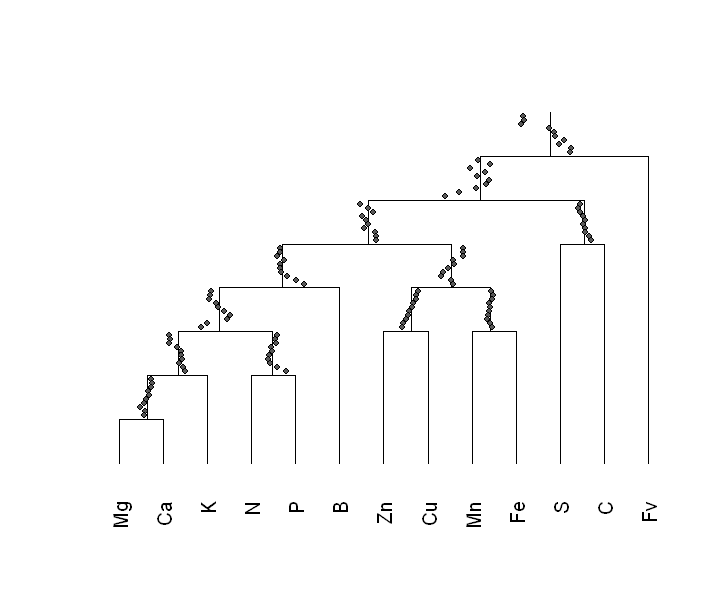

In [8]:
grouping <- cut(atoca$Rendement, breaks = 10)
grouping <- factor(grouping, levels = rev(levels(grouping)))

options(repr.plot.width=6, repr.plot.height=5)
CoDaDendrogram2(comp, V = psi,
                range = 'auto', equal.height = TRUE, type = 'conf', conf.level = 0,
                show.range = FALSE, group = grouping, pch.col = FALSE)

### Check for outliers
I'm using `sign2` with a loose criteria to detect potential outliers. The pairs plot shows outliers in black.

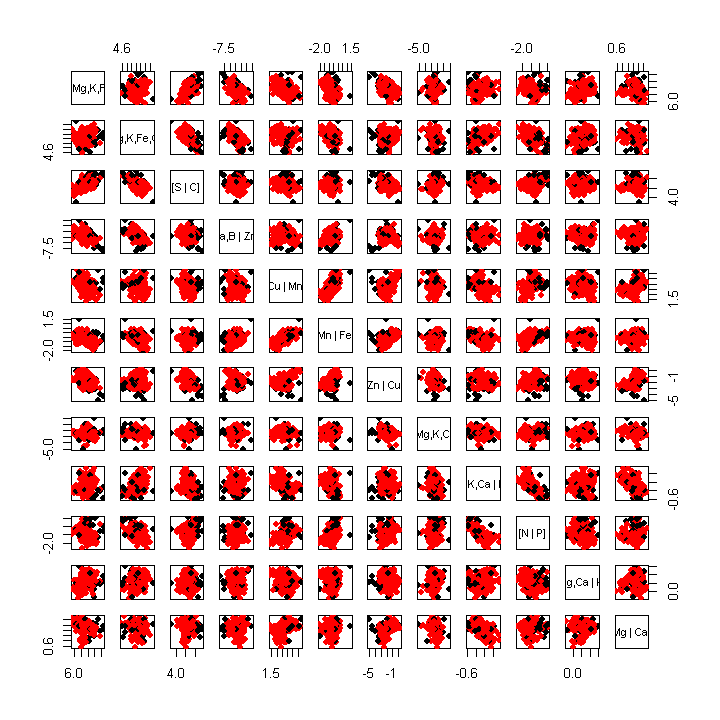

In [9]:
options(repr.plot.width=6, repr.plot.height=6)
out_test <- sign2(unclass(bal), qcrit = 0.999)
pairs(bal, col = factor(out_test$wfinal01), pch=16)

I keep the inliers in the `bal_in` object.

In [10]:
bal_in = bal[out_test$wfinal01 == 1, ]

Just for sake of data mining, we can do a pca and ceck if there is a trend with cranberry yield.

Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."

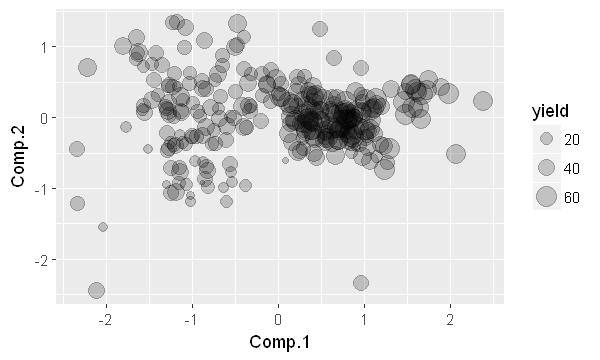

In [11]:
options(repr.plot.width=5, repr.plot.height=3)
bal_pca = princomp(bal, cor=FALSE)
gg_pca = data.frame(bal_pca$scores[, 1:2], yield = atoca$Rendement)
ggplot(gg_pca, aes(x = Comp.1, y = Comp.2)) +
  geom_point(aes(size = yield), alpha=0.2)

Some regions are definitly yielding low, showing potential trends in the data.

## Linear regression
For sake of statistical testing, I test if yield can be described by a linear combinaision of balances. If one wants to compare coefficients, variables should be scaled (zero mean and unit standard deviation).

In [20]:
bal_sc <- scale(bal)
colnames(bal_sc) <- ilrDef

In [21]:
bal_df <- data.frame(bal_sc, yield = atoca$Rendement)
mod1 <- lm(yield ~ ., bal_df) # log10 of yield could also be used
summary(mod1)


Call:
lm(formula = yield ~ ., data = bal_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-25.8051  -6.5717  -0.2561   6.6827  24.4092 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            40.0493     0.5641  70.996  < 2e-16 ***
X.S.C.N.Zn.P.Mn.Mg.K.Fe.Cu.Ca.B...Fv.  -1.9681     1.6937  -1.162 0.246239    
X.N.Zn.P.Mn.Mg.K.Fe.Cu.Ca.B...S.C.     -6.0682     2.1117  -2.874 0.004377 ** 
X.S...C.                               -6.8642     2.0775  -3.304 0.001080 ** 
X.N.P.Mg.K.Ca.B...Zn.Mn.Fe.Cu.         -6.7107     1.3601  -4.934  1.4e-06 ***
X.Zn.Cu...Mn.Fe.                        0.6384     1.1624   0.549 0.583343    
X.Mn...Fe.                              0.5219     1.0434   0.500 0.617325    
X.Zn...Cu.                              2.8604     0.9055   3.159 0.001760 ** 
X.N.P.Mg.K.Ca...B.                     -1.0229     0.6961  -1.469 0.142862    
X.Mg.K.Ca...N.P.                        1.208

In `R`, there is a very useful package named `MCMCpack`, which can easily handle bayesian statistics. I'm not using it here to keep focus. Just saying. 

In [13]:
#library(MCMCpack)
#model1_bayes = MCMCregress(yield ~ ., bal_df)

We verify the distribution of residues. The null hypothesis is that residues are normally distributed.

In [22]:
shapiro.test(residuals(mod1))


	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.99687, p-value = 0.8511


The null hypothesis is not rejected at a 0.05 level. Great, but let's see how the linear model behaves.

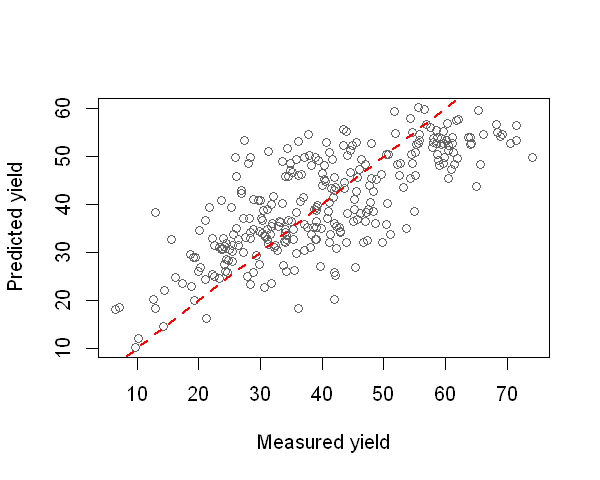

In [23]:
options(repr.plot.width=5, repr.plot.height=4)
plot(atoca$Rendement, predict(mod1),
     xlab = "Measured yield",
     ylab = "Predicted yield",
    col='gray40')
abline(a=0,b=1, col="red", lty = 2, lwd = 2)

I have to say that this is unusually good for ecological data. But a linear statistical model describes the effects: it doesn't predict anything.

This is where machine learning come to play.

## Machine learning
In ML, we either regress to predict continuous values or classify to predict categories. Of course, yield is continuous. But for diagnosis and decision-making, continuous values are difficult to interpret.

### Yield as continuous target
Anyways, let's try a regression model. In ML, we need to split data into a training set, on which the model will be fitted, and a testing set used to test how the model behaves with data which were not used for fitting.

In [27]:
set.seed(534636)
inTrain <- createDataPartition(y = bal_df$yield, p = .70, list = FALSE) # indexes of the training set
training <- bal_df[inTrain, ] # training set
testing <- bal_df[-inTrain, ] # testing set

Many algotithms cans be tested. In my experience, **KNN**s usually work great with ilrs. Beware that fitting ML can be a long process...

In [28]:
grid <- expand.grid(kmax = seq(2, 10, by = 2),
                    distance = seq(0.2, 2, by = 0.2),
                    kernel = 'optimal') # grid of parameters to try
ml_kknn_reg = train(yield ~ ., data = training, method = "kknn", tuneGrid = grid, tuneLength = 10) # long process

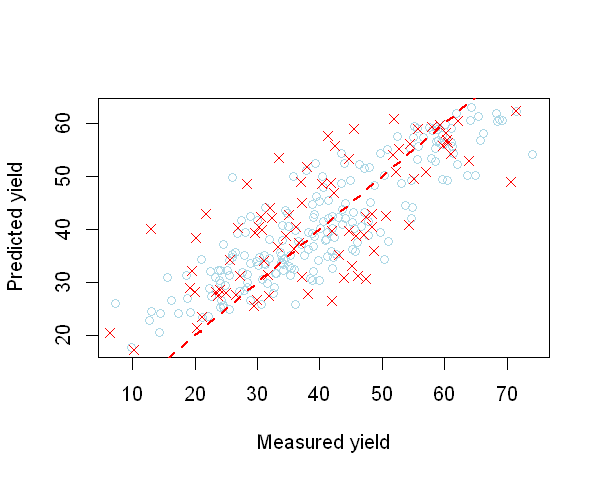

In [29]:
options(repr.plot.width=5, repr.plot.height=4)
plot(bal_df[inTrain, 'yield'], predict(ml_kknn_reg),
     xlab = "Measured yield",
     ylab = "Predicted yield",
    col='lightblue')
points(bal_df[-inTrain, 'yield'], predict(ml_kknn_reg, testing),
    col='red', pch=4)
abline(a=0,b=1, col="red", lty = 2, lwd = 2)

The `caret` package allows to plot an index of importance of variables. Each algorithm ha its own meaning of "importance" of variables. We should be careful on what "importance" means, case by case.

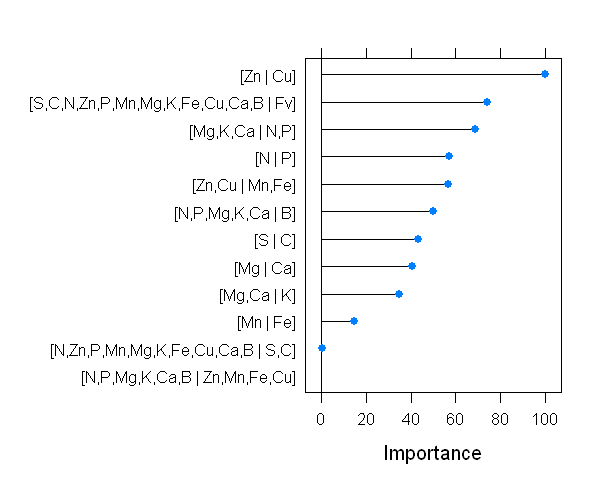

In [30]:
vI = varImp(ml_kknn_reg)
rownames(vI$importance) = ilrDef
plot(vI)

## Yield as ordered category

For dagnosis purposes, yield can be segmented in categories, usually only two.

   0%   25%   50%   75%  100% 
 6.45 29.89 39.05 50.05 74.14 


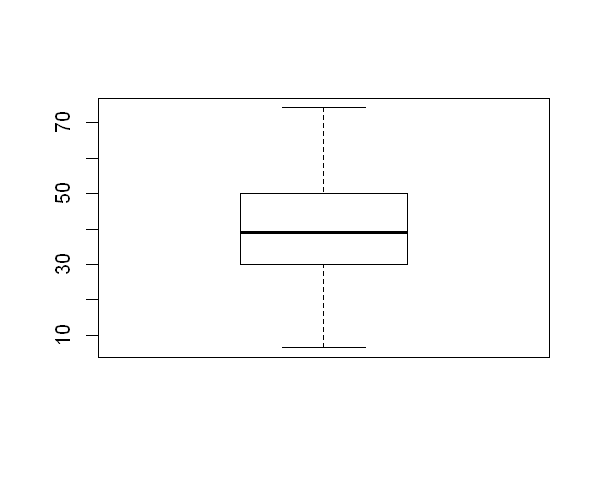

In [20]:
print(quantile(bal_df$yield))
boxplot(bal_df$yield) 

A delimiter of 50 t/ha seems reasonnable.

In [21]:
yield_delimiter = 50
bal_df$yieldclass = cut(bal_df$yield, c(0, yield_delimiter, 75))
levels(bal_df$yieldclass) = c('LY', 'HY')
training = bal_df[inTrain, -13] # training set
testing = bal_df[-inTrain, -13] # testing set

In [22]:
grid = expand.grid(kmax = seq(10, 30, by = 5),
                   distance = 1.2,#seq(0.6, 3, by = 0.2), 
                   kernel = 'optimal') # grid of parameters to try
ml_kknn_clf = train(yieldclass ~ ., 
                    data = training, 
                    method = "kknn", 
                    tuneGrid = grid, 
                    tuneLength = 20) # long process

The contingency tables in the training and testing sets.

In [23]:
ct_train = table(Measured = bal_df[inTrain, 'yieldclass'], 
                 Predicted = predict(ml_kknn_clf))
ct_train

        Predicted
Measured  LY  HY
      LY 149  13
      HY   8  46

In [24]:
ct_test = table(Measured = bal_df[-inTrain, 'yieldclass'], 
                Predicted = predict(ml_kknn_clf,testing))
ct_test

        Predicted
Measured LY HY
      LY 50  3
      HY  3 15

The accuracy in the testing set.

In [25]:
(ct_test[1, 1] + ct_test[2, 2]) / sum(ct_test)

[1] 0.915493

The optimal parameters of the model.

In [26]:
ml_kknn_clf

k-Nearest Neighbors 

216 samples
 12 predictor
  2 classes: 'LY', 'HY' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 216, 216, 216, 216, 216, 216, ... 
Resampling results across tuning parameters:

  kmax  Accuracy   Kappa    
  10    0.7972343  0.4785198
  15    0.7972343  0.4785198
  20    0.7972343  0.4785198
  25    0.7972343  0.4785198
  30    0.7972343  0.4785198

Tuning parameter 'distance' was held constant at a value of 1.2

Tuning parameter 'kernel' was held constant at a value of optimal
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were kmax = 30, distance = 1.2 and kernel
 = optimal.

With KNNs, we can generate an imbalance index by computing the distance between a point and the mean nearest K balanced points in the ilr space. First, we must isolate the reference population, the one have high yield which can be correctly predicted, i.e. the true negatives (truely not sick).

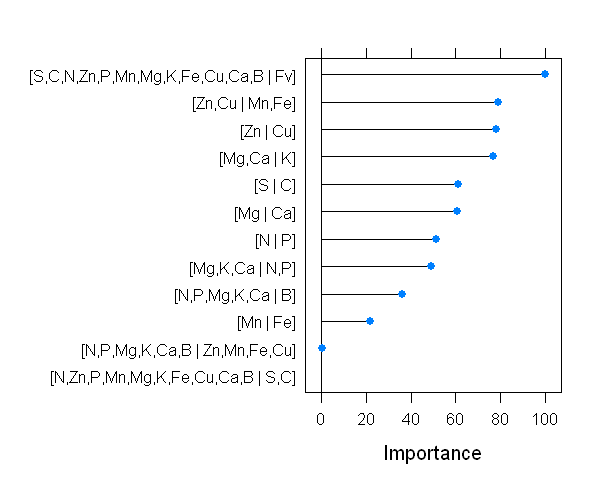

In [27]:
vI = varImp(ml_kknn_clf)
rownames(vI$importance) = ilrDef
plot(vI)

## Assessing imbalance

The euclidean distance as imbalance index is not always good. Let's see how it behaves in this case. First, I create a vector containing the predictions of the model. This vector is a series of `LY` and `HY` values. The `TN` object is a data frame containing the ionomes of true negatives, i.e. whose actual and predicted values are high yields.

In [29]:
predicted = predict(ml_kknn_clf, bal_df %>% dplyr::select(-matches("yield")))
TN = bal_df[bal_df$yieldclass == 'HY' & predicted == 'HY', ]

I also create a quick function returning the euclidean distance between the values of two vectors.

In [30]:
euclidean_distance = function(x1, x2) (sqrt(sum(x1-x2)^2))

The following function will be applied to each observation. I checks if the observation is predicted as `LY` or `HY`. Then it computes the euclidean distance between the observation and the mean of the `k_nearest` (let's say 10) nearest balanced points. It also checks if the mean of the nearest balanced points is indeed a `HY`, just in case the mean falls into a `LY` hole.

In [31]:
balance_knn = function(observed_bal, bal_dataset, model, k_nearest) {
    # The model must return either LY or HY
    is_obs_balanced = predict(model, observed_bal) == 'HY'
    
    distances = apply(bal_dataset, 1, euclidean_distance, x2=observed_bal)
    nearest = names(sort(distances, decreasing=TRUE)[1:k_nearest])
    reference_bals = bal_dataset[rownames(bal_dataset) %in% nearest, ]
    reference_bal = apply(reference_bals, 2, mean)
    reference_bal = t(data.frame(reference_bal))
    
    is_ref_balanced = predict(ml_kknn_clf, reference_bal) == 'HY'
    
    imbalance_index = euclidean_distance(reference_bal, observed_bal)
    return(list(is_obs_balanced, is_ref_balanced, imbalance_index, reference_bals))
}

Here I'm aranging the balances matrix as a data frame, and I create a data frame where the diagnostic will be stored.

In [32]:
observed_bal = data.frame(bal)
colnames(observed_bal) = colnames(training)[-13]
diagnostic = data.frame(matrix(ncol = 3, nrow = nrow(observed_bal)))
colnames(diagnostic) = c("obs_is_balanced", "ref_is_balanced", "imbalance_index")

The following loop computes the diagnosis for every observed balance. It's a long process, and probably a highly sub-optimal approach in terms of computation efficiency.

In [33]:
reference_bals_l = list()
for (i in 1:nrow(observed_bal)) {
    output = balance_knn(observed_bal = observed_bal[i, ], 
                                  bal_dataset = TN[, 1:12], 
                                  model = ml_kknn_clf, 
                                  k_nearest=10)
    diagnostic[i, 1] = output[[1]]
    diagnostic[i, 2] = output[[2]]
    diagnostic[i, 3] = output[[3]]
    reference_bals_l[[i]] = output[[4]]
}

I put the yield and yield class in the diagnosis table to make thing pretty for plotting.

In [34]:
diagnostic$yield = atoca$Rendement
diagnostic$yieldclass = cut(atoca$Rendement, c(0, yield_delimiter, 75))
levels(diagnostic$yieldclass) = c('LY', 'HY')

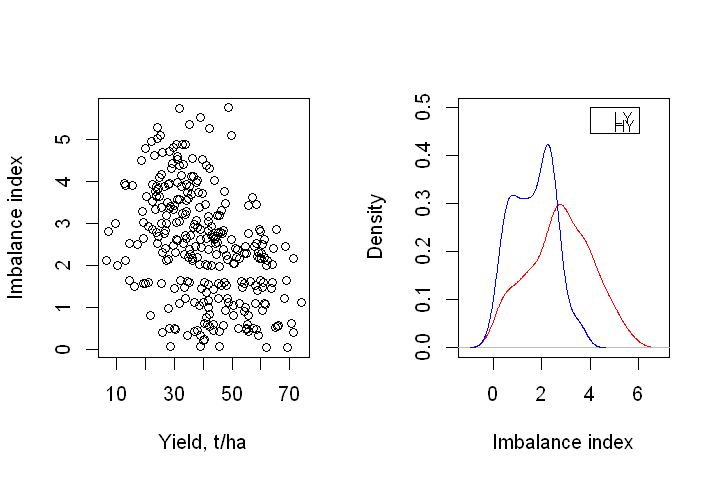

In [35]:
options(repr.plot.width=6, repr.plot.height=4)
par(mfrow=c(1, 2))
plot(diagnostic$yield, diagnostic$imbalance_index, 
     xlab="Yield, t/ha", ylab="Imbalance index")
plot(density(diagnostic$imbalance_index[diagnostic$yieldclass == 'LY']),
    main="", xlab="Imbalance index", col="red", ylim=c(0, 0.5))
lines(density(diagnostic$imbalance_index[diagnostic$yieldclass == 'HY']),
     col="blue")
legend(4, 0.5, legend=c("LY", "HY"),
       col=c("red", "blue"), cex=0.8)

From the first plot it's obvious that there is a trend between yield and imbalance index, but it's very noisy. The density plots show that high yielders have generally a lower imbalance index, but low yielders have a broad range of values, corevering high yielders. The imbalance index is not suitable here.

For a signle observation, it is possible to plot it's position in a CoDa dendrogram, with the statistics of its reference (the confidence range of the nearest values is to interpret with care when it has few values, here just 10).

It's not obvious which color is the reference and which is the observed. If you check the numbers, red is the observed and green is the reference.

In [36]:
i=10
observed_bal = bal[i, ]
codadend_df = rbind(reference_bals_l[[i]], observed_bal, observed_bal)
codadend_df$group = c(rep('reference', 10), 'observed', 'observed')

Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(c(), class = c(class(x), class(y))):
"Cal

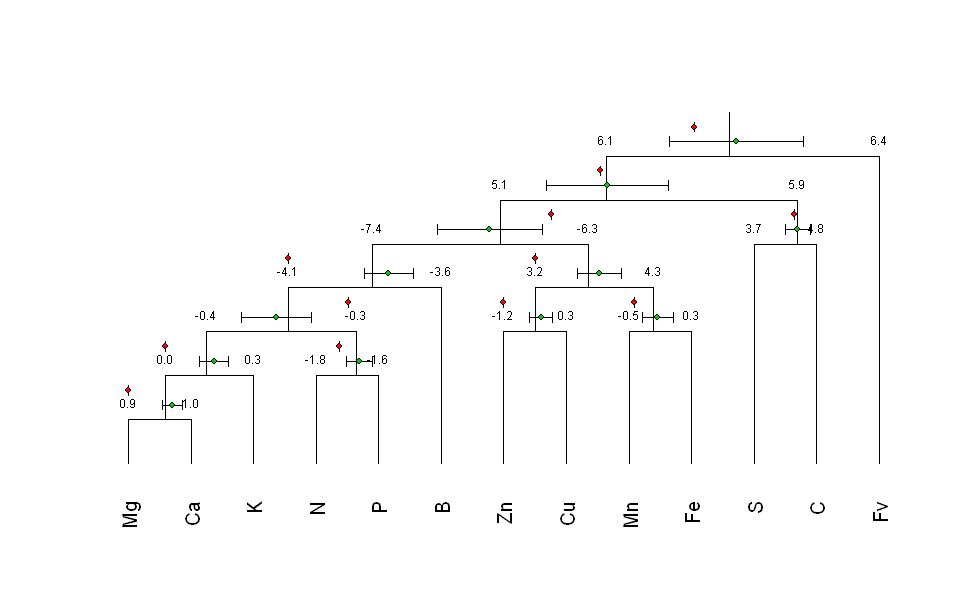

In [37]:
options(repr.plot.width=8, repr.plot.height=5)
CoDaDendrogram2(ilrInv(codadend_df[, -13], V=psi), V = psi,
                range = 'auto', equal.height = TRUE, type = 'conf', conf.level=0.95,
                 group = factor(codadend_df$group),
                show.range = TRUE)

In [38]:
imbalance_index = euclidean_distance(apply(reference_bals_l[[i]], 2, mean), observed_bal)
imbalance_index

[1] 2.137697

## The Cate-Nelson approach

What we did was the latest approach I retained. But in most papers I published, I used an *in-house* approach based on the binary classification approach, similar to the *Sufficiency levels of available nutrients* concept known as the Cate-Nelson approach in agriculture ([Nelson 1975](http://agris.fao.org/agris-search/search.do?recordID=SE19760060645); example in a [FAO document](http://www.fao.org/docrep/018/ar118e/ar118e.pdf), page 33).

Here, I loop across several `qcrit` thresholds to recover a sensitivity versus sensitivity curve for the training set.

In [40]:
in_train = createDataPartition(y = bal_df$yield, p = .75, list = FALSE) # indexes of the training set
training = bal_df[in_train, ] # training set
testing = bal_df[-in_train, ] # testing set

In [41]:
qcrit_vector = seq(0.950, 0.999, by = 0.001) # ajust minimum value if an error message is returned from the sign1_ref function
senspe = matrix(ncol = 2, nrow = length(qcrit_vector))
colnames(senspe) = c("Sensitivity", "Specificity")

sign1_results = list()
for (j in 1:length(qcrit_vector)) {
  sign1_results[[j]] = sign1_ref(mv = training[, -c(13, 14)], Y = training[, 13], Ycut = yield_delimiter, 
                                 niter = 20, qcrit = qcrit_vector[j])
  classification = biclass(x=sign1_results[[j]]$mv.dist, y = training[, 13],
                           xl = sign1_results[[j]]$const, yl = yield_delimiter)$classification
  senspe[j, 1] = sum(classification == "TP") / (sum(classification == "TP") + sum(classification == "FN"))
  senspe[j, 2] = sum(classification == "TN") / (sum(classification == "TN") + sum(classification == "FP"))
}

The `senspe` matrix is used to plot a ROC curve. This needs several steps. First, I add theoretical values where sensitivity is 1 and specificity is 0, and where sensitivity is 0 and specificity is 1.

In [42]:
senspe = rbind(c(1, 0), senspe, c(0, 1))

Then I compute the AUC (area under the curve) index...

In [43]:
sAUC = vector()
sAUC[1] = senspe[1,2]*senspe[1,1]
for (i in 2:nrow(senspe)) sAUC[i] = (senspe[i,2]-senspe[i-1,2])*senspe[i,1]
AUC = sum(sAUC, na.rm = TRUE)

... as well as the Youden index ($Sensitivity + Specificity - 1$).

In [44]:
youden <- apply(senspe, 1, function(X) sum(X) - 1)
optXi = which.max(youden)

The following code produces a ROC plot.

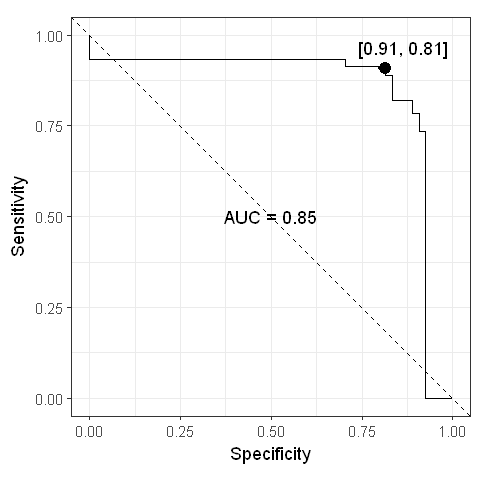

In [45]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(data = data.frame(senspe), aes(x = Specificity, y = Sensitivity)) +
  theme_bw() +
  geom_step(direction = "vh") +
  geom_abline(intercept = 1, slope= -1, lty=2) +
  geom_point(data = data.frame(senspe)[optXi, ], size=3) +
  geom_text(data = data.frame(senspe)[optXi, ],
            label = paste("[", round(senspe[optXi, 1], 2), ", ", 
                          round(senspe[optXi, 2], 2), "]", sep=""),
            hjust=0.3, vjust=-1) +
  geom_text(data = data.frame(Specificity = 0.5, Sensitivity = 0.5),
            label = paste("AUC = ", round(AUC, 2), sep="")) +
  coord_equal()

The optimal value for qcrit is the following.

In [46]:
qcrit_vector[optXi]

[1] 0.959

I will not print it here, but the information for the partition done with the optimal `qcrit` can be recovered in the `sign1_results[[optXi]]` object. I'm using this object for the binary classification (Cate-Nelson)

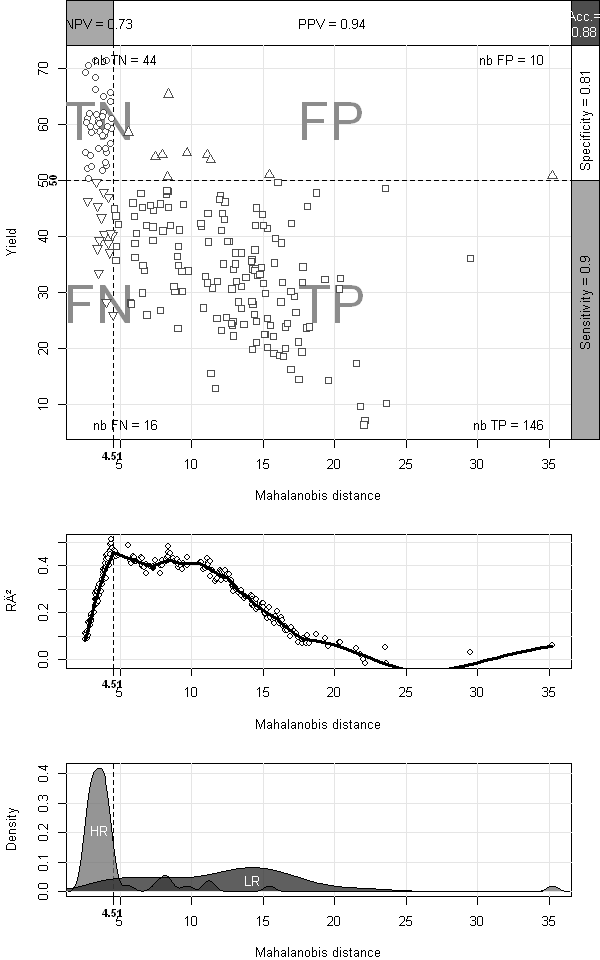

In [47]:
options(repr.plot.width=5, repr.plot.height=8)
bin_class_train = CateNelson(x = sign1_results[[optXi]]$mv.dist, y = training$yield,
                             xcn = sign1_results[[optXi]]$const, ycn = yield_delimiter,
                             TNpos = "ul", xlab = expression("Mahalanobis distance"), ylab = "Yield",
                             draw.ellipse = "none",
                             anovm = TRUE, anovm.span = 0.1, anovm.degree = 1,
                             dens.plot = TRUE, colors = "greys")

We get an accuracy of 0.89 with the training set. This is pretty good! Now let's try with the testing set.

To do this I isolate the balances of the reference population (true high yielders), `thy`.

In [48]:
thy = training[sign1_results[[optXi]]$mv.dist <= sign1_results[[optXi]]$const & 
               training$yield > yield_delimiter, -c(13, 14)]

Then I compute the Mahalanobis distance between the testing set and the reference population.

In [49]:
invCov = ginv(cov(thy)) # I invert the matrix separetly with the robust ginv function (MASS package)
test_mv.dist = sqrt(mahalanobis(testing[ , -c(13, 14)], 
                                center = apply(thy, 2, median), 
                                cov = invCov, 
                                inverted = TRUE)) 

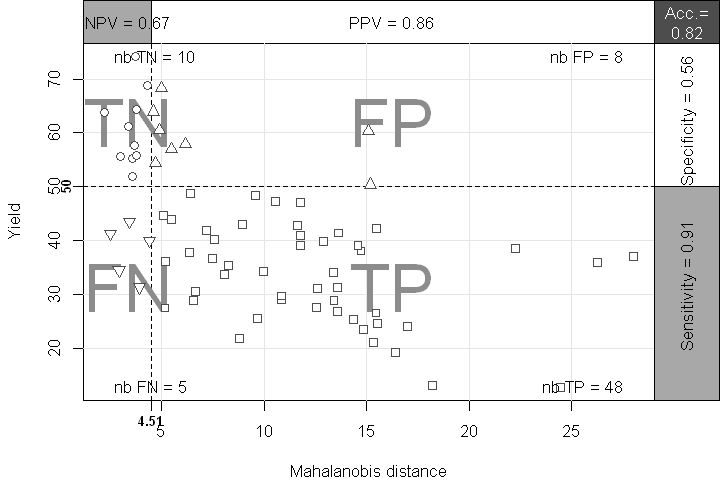

In [50]:
options(repr.plot.width=6, repr.plot.height=4)
bin_class_test = CateNelson(x = test_mv.dist, y = testing$yield,
                            xcn = sign1_results[[optXi]]$const, ycn = yield_delimiter,
                            TNpos = "ul", xlab = expression("Mahalanobis distance"), ylab = "Yield",
                            draw.ellipse = "none",
                            anovm = FALSE,
                            dens.plot = FALSE,
                            colors = "greys")

The testing accuracy is 0.79. Not so bad, but below what we get with KNNs.

## DRIS

The DRIS is usually not conducted with training and testing sets. I could do it, but I guess at this point you can figure out how it can be done. Here I'm using the whole data set. The DRIS function takes a collection of high yielders, a collection of low yielders and a data set on which we want to compute the imbalance indices.

But when I first ran the DRIS function it failed because there is a zero value in the data set, in the iron column, on line 225. Let's impute this value as 65% of the lowest measurement.

In [51]:
zero_imp = function(x, rate=0.65) {
    x[x==0] = rate * min(x[x>0])
    return(x)
}
parts_imp = apply(parts, 2, zero_imp)

For isolation of low and high yielders, in percentage.

In [52]:
high_yielders = parts_imp[atoca$Rendement >= yield_delimiter, -13] / 10000
low_yielders = parts_imp[atoca$Rendement < yield_delimiter, -13] / 10000

The DRIS function include several methods. The Beaufils method is the classical one.

In [53]:
i=1:10 # argument obs must contain at least two rows
dris_i = DRIS(obs = parts_imp[i, -13] / 10000, 
              ref.hy=high_yielders, 
              ref.ly=low_yielders,
              method="Beaufils")

In [54]:
dris_i$Index

B,Ca,Cu,Fe,K,Mg,Mn,P,Zn,N,C,S
0.06606111,-1.0012492,0.88100111,-0.1470924,3.25744015,0.1746577,-0.74192784,0.2761492,0.4171985,-2.3372454,0.6186254490,-1.46361830
-0.95883559,0.3705762,0.23089634,0.2334644,1.03444349,1.2040973,-1.51798791,0.7040106,0.8218244,-1.7638275,0.3558257024,-0.71448736
0.49948454,-0.3352700,-0.42236072,1.8508442,0.20638529,0.7926367,-1.05089169,-0.4328939,0.5528011,-0.7518617,-0.0512436627,-0.85763012
-0.59329363,-0.2847561,-0.36510665,1.0989168,0.63918754,1.0906048,-1.27937039,0.1998793,0.7247023,-1.1290017,0.1445670060,-0.24632929
-0.38257121,-0.3621281,0.64939613,0.4967276,-0.18758101,0.7500797,0.05469088,-0.4528397,0.3417799,-0.4566103,-0.1048941867,-0.34604976
-0.79149209,0.2422710,-0.10007938,-0.2774750,-0.19658697,1.1672187,-0.37344033,0.3124707,0.4831523,-0.3503757,-0.1784764647,0.06281320
-0.67934459,-0.3659084,0.39397953,2.2808733,-0.55999543,0.3796897,0.36226436,-0.4463060,0.2818398,-0.2020744,-0.5873487721,-0.85766919
-1.24310824,-0.1996018,0.07345773,1.1637386,-0.05079655,0.8884791,-0.97524017,0.3197256,0.5257259,0.1099351,-0.0008333157,-0.61148201
0.34263819,-0.1976793,-0.47331686,0.3376224,-0.03721161,0.4047769,-0.30383521,-0.1578112,0.2944318,0.3669648,-0.4855948221,-0.09098494
-0.76225885,-0.2100305,-0.38708717,-0.4742901,-0.43361474,0.8603274,-0.41421770,0.5372788,0.4381843,0.8077815,-0.2456443418,0.28357141


In [55]:
dris_i$IBN

[1] 0.9485222 0.8258564 0.6503586 0.6496430 0.3821124 0.3779877 0.6164411
 [8] 0.5135103 0.2910723 0.4878572